<h1>GoldenBootHunter</h1>
Introducing GoldenBootHunter: Your go-to app for identifying football's golden boot winners. Using a pretrained MobileNetV2 model and a dataset of 22 legends, it effortlessly recognizes iconic players from images. Explore the history of goal-scoring greatness with precise and reliable identification. Celebrate football excellence at your fingertips. Join the hunt for the golden boot stars!

> Model Used : MobileNetV2


> Datset Used : [Golden Boot Football Players
](https://kaggle.com/datasets/balabaskar/golden-foot-football-players-image-dataset/data)


> Total players : 22

Lables:
* Alessandro Del Piero
* Andreas Iniesta
* Andriy Shevchenko
* Cristiano Ronaldo
* Didier Drogba
* Diego Maradona
* Edinson Cavani
* Francesco Totti
* Gianlugi Buffon
* Iker Casillas
* Lionel Messi
* Luka Modric
* Mohamed Salah
* Pavel Nedved
* Pele
* Riyan Giggs
* Roberto Baggio
* Roberto Carlos
* Ronaldinho
* Ronaldo Nazario
* Samuel Eto
* Zlatan Ibrahimovic











###Import Statements




In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import numpy

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet

###Data Download

> kaggle installed and kaggle api is called to fetch dataset

> Configuration dictionary is set








In [3]:
!pip install -q kaggle

In [5]:
CONFIGURATION = {
      "BATCH_SIZE":32,
      "IM_SIZE":224,
      "LEARNING_RATE": 0.1,
      "N_EPOCHS": 20,
      "DROPOUT_RATE": 0.0,
      "REGULARIZATION_RATE": 0.0,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES": 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 100,
      "N_DENSE_2": 10,
       "NUM_CLASSES":22

}

In [5]:
!mkdir /root/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d balabaskar/golden-foot-football-players-image-dataset

100% 516M/517M [00:29<00:00, 21.2MB/s]
100% 517M/517M [00:29<00:00, 18.2MB/s]


In [9]:
!unzip "/content/golden-foot-football-players-image-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/7728f17fc5.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/7777fa403a.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/782dc5f4e4.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/788e368e20.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/79384a589c.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/79a8acf2bf.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/79f0a00f23.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/79f2eccc82.jpg  
  inflating: /content/dataset/football_golden_foot/football_golden_foot/edinson_cavani/7a27a4b4fb.jpg  
  inflating: 

###Dataset Fetch

> Data fetched as tensorflow dataset


> Sparse Categorical labeling is used





In [3]:
directory = "/content/dataset/football_golden_foot/football_golden_foot"

In [6]:
#generates image label from directory structure(angry te images etc)
#seed for shuffling runtime
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,


)

Found 7188 files belonging to 22 classes.


In [7]:
CLASS_NAME = dataset.class_names
CLASS_NAME

['alessandro_del_piero',
 'andreas_iniesta',
 'andriy_shevchenko',
 'cristiano_ronaldo',
 'didier_drogba',
 'diego_maradona',
 'edinson_cavani',
 'francesco_totti',
 'gianlugi_buffon',
 'iker_casillas',
 'lionel_messi',
 'luka_modric',
 'mohamed_salah',
 'pavel_nedved',
 'pele',
 'riyan_giggs',
 'roberto_baggio',
 'roberto_carlos',
 'ronaldinho',
 'ronaldo_nazario',
 'samuel_eto',
 'zlatan_ibrahimovic']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[15  3 15 16  8 10 11 13  6 16  1  0 10 21 16  5  0 11  8  0  6  1  9  0
  2  5 17  3 11 18  7 19]


###Data Visualization

> Dataset visualized using matplotlib



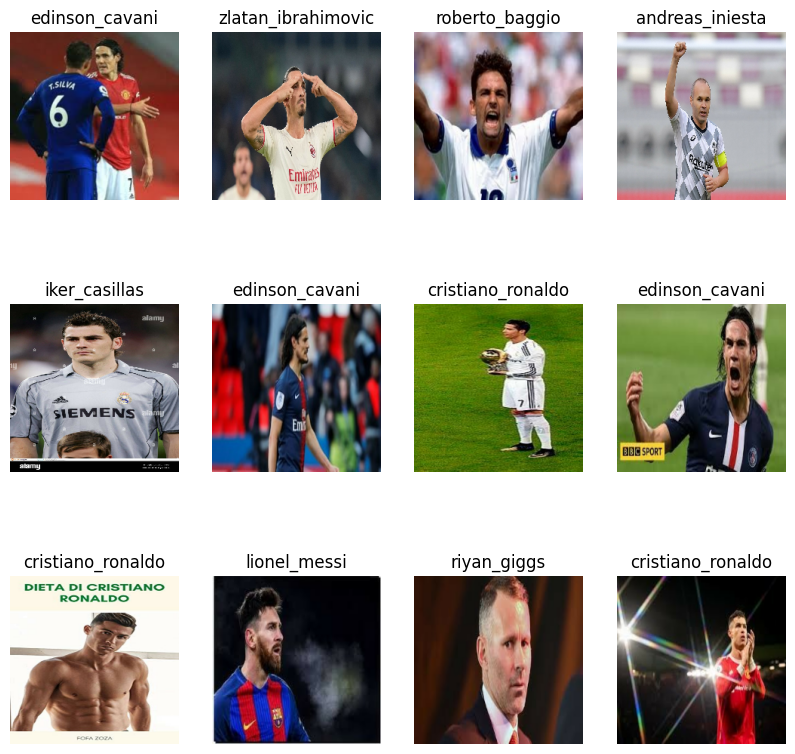

In [35]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(CLASS_NAME[labels_batch[i]])
        plt.axis("off")

###Pre-processing

> Prefetch dataset conversion done for faster data training

> Data augmentation applied(Contrast based,Horizontal Flip,Rotation of Data) for training data

> Data normalization applied for all data




In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [52]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: in user code:

    File "<ipython-input-20-72be54cc0777>", line 2, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)

    NameError: name 'data_augmentation' is not defined


In [12]:
train_ds = train_ds.map(
    lambda x, y: (resize_rescale_layers(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
val_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
val_ds = val_ds.map(
    lambda x, y: (resize_rescale_layers(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
test_ds = test_ds.map(
    lambda x, y: (resize_rescale_layers(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

###Model Architecture(from Scratch)

> A scratch model used



In [ ]:
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
    print("No GPU available.")
else:
    # Specify GPU device for model creation
    with tf.device('/GPU:0'):
        # Define or load your model
        IM_SIZE = CONFIGURATION['IM_SIZE']
        DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
        REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
        N_FILTERS = CONFIGURATION['N_FILTERS']
        KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
        POOL_SIZE = CONFIGURATION['POOL_SIZE']
        N_STRIDES = CONFIGURATION['N_STRIDES']

        #Input layer shape (None,None,3) means arbitary image dimension with RGB layer

        lenet_model_gpu = tf.keras.Sequential([
            InputLayer(input_shape=(None, None, 3)),
            resize_rescale_layers,

            Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid',
                   activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
            BatchNormalization(),
            MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),
            Dropout(rate=DROPOUT_RATE),

            Conv2D(filters=N_FILTERS * 2 + 4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid',
                   activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
            BatchNormalization(),
            MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),

            Flatten(),

            Dense(CONFIGURATION['N_DENSE_1'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
            BatchNormalization(),
            Dropout(rate=DROPOUT_RATE),

            Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
            BatchNormalization(),

            Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
        ])

# Display the model summary
lenet_model_gpu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [24]:
loss_function = SparseCategoricalCrossentropy()
#Sparse categorical
#logits tensor is the output of multiclass classification before passing it in softmax
#less loss -> more accurate

In [ ]:
# Compile the model
lenet_model_gpu.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

In [ ]:

history = lenet_model_gpu.fit(
    train_ds,
    validation_data =val_ds,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,

    )

Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 3.1086 - accuracy: 0.0802

###MobileNetV1 Model



> Image Size used : (224,224,3)


> One flatten layer and a dense layer of 100 labels is also used


> weight used of imagenet







In [25]:
IMAGE_SIZE = [224, 224]
# vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
mobilenet = MobileNet(
    input_shape=IMAGE_SIZE+[3],
    alpha=0.75,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet"
)

10626956/10626956 [==============================] - 1s 0us/step


In [26]:
mobilenet.summary()

Model: "mobilenet_0.75_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 24

In [28]:
# mobilenet.trainable = True

# set_trainable = False

# for layer in mobilenet.layers:
#   if layer.name == 'block5_conv1':
#     set_trainable = True
#   if set_trainable:
#     layer.trainable = True
#   else:
#     layer.trainable = False

# for layer in mobilenet.layers:
#   print(layer.name,layer.trainable)

In [27]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [28]:
# our layers - you can add more if you want
# x = Flatten()(vgg16.output)
# x  = Flatten()(mobilenet.output)
x  = GlobalAveragePooling2D()(mobilenet.output)

In [29]:
x = Dense(256, activation='relu')(x)

In [30]:
x = Dense(100, activation='relu')(x)

In [31]:
prediction = Dense(len(CLASS_NAME), activation='softmax')(x)

# create a model object
model = Model(inputs=mobilenet.input, outputs=prediction)

In [ ]:
# # create a model object
# model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(CLASS_NAME[labels_batch[i]])
        plt.axis("off")

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 24)      96    

###Model Train

> epochs used : 20



In [66]:
loss_function = SparseCategoricalCrossentropy()
#Sparse categorical
#logits tensor is the output of multiclass classification before passing it in softmax
#less loss -> more accurate

In [33]:
# Compile the model
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

In [34]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')


In [35]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)

Epoch 1/20


<ipython-input-35-3a90bfa3cca7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


180/180 [==============================] - 73s 265ms/step - loss: 2.7987 - accuracy: 0.1783 - val_loss: 2.3321 - val_accuracy: 0.3196
Epoch 2/20
180/180 [==============================] - 7s 39ms/step - loss: 2.0580 - accuracy: 0.3958 - val_loss: 1.8588 - val_accuracy: 0.4574
Epoch 3/20
180/180 [==============================] - 8s 42ms/step - loss: 1.5875 - accuracy: 0.5309 - val_loss: 1.5041 - val_accuracy: 0.5724
Epoch 4/20
180/180 [==============================] - 7s 37ms/step - loss: 1.2609 - accuracy: 0.6306 - val_loss: 1.3507 - val_accuracy: 0.6080
Epoch 5/20
180/180 [==============================] - 7s 37ms/step - loss: 0.9930 - accuracy: 0.7095 - val_loss: 1.1715 - val_accuracy: 0.6619
Epoch 6/20
180/180 [==============================] - 7s 37ms/step - loss: 0.7825 - accuracy: 0.7832 - val_loss: 1.0407 - val_accuracy: 0.7102
Epoch 7/20
180/180 [==============================] - 7s 41ms/step - loss: 0.6064 - accuracy: 0.8286 - val_loss: 1.0119 - val_accuracy: 0.7273
Epoch 8/

In [ ]:
print("hello")

hello


In [36]:
model_path = "/content/gdrive/My Drive/FootBallerMobileNet.h5"
model.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Model Evaluation

In [38]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

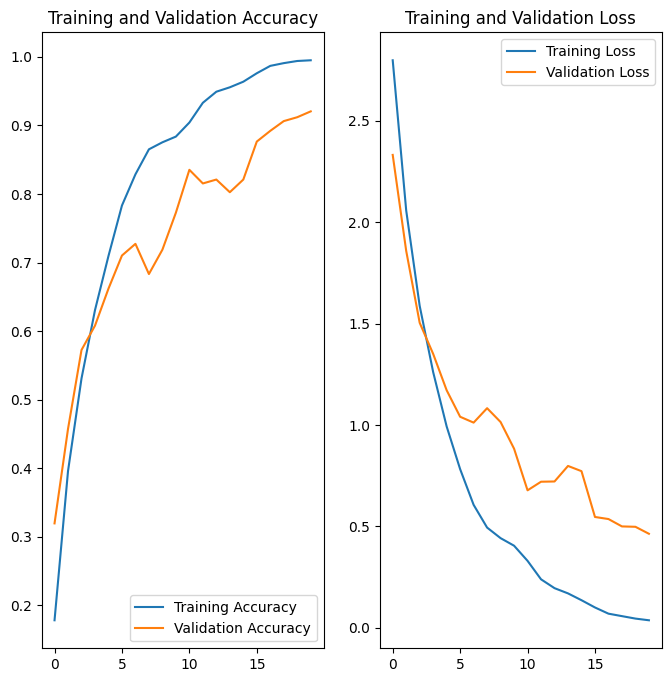

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(CONFIGURATION['N_EPOCHS']), acc, label='Training Accuracy')
plt.plot(range(CONFIGURATION['N_EPOCHS']), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(CONFIGURATION['N_EPOCHS']), loss, label='Training Loss')
plt.plot(range(CONFIGURATION['N_EPOCHS']), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_ds)

In [16]:
MODEL = tf.keras.models.load_model("/content/FootBallerMobileNet.h5")

In [17]:
MODEL.evaluate(test_ds)

23/23 [==============================] - 27s 63ms/step - loss: 0.4835 - accuracy: 0.9296


[0.48352551460266113, 0.9295580387115479]

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = CLASS_NAME[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


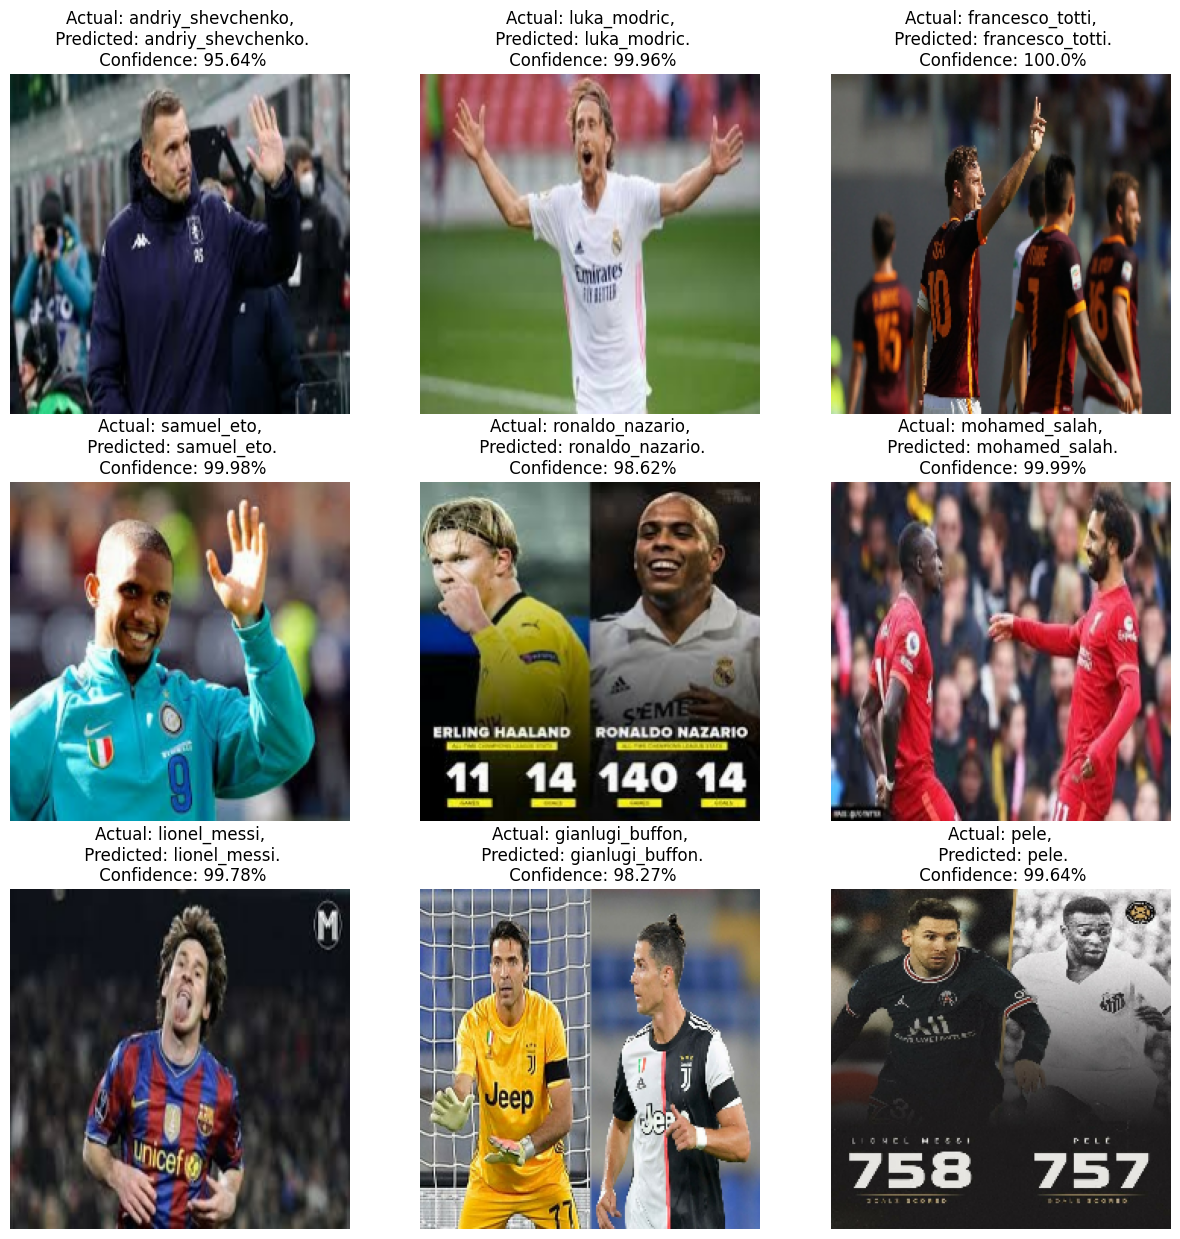

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        test_im = (images[i]*255.).numpy()
        plt.imshow(test_im.astype("uint8"))

        predicted_class, confidence = predict(MODEL, images[i].numpy())
        actual_class = CLASS_NAME[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [21]:
test_img = cv2.imread('/content/ronaldo.jpg')

(-0.5, 804.5, 1052.5, -0.5)

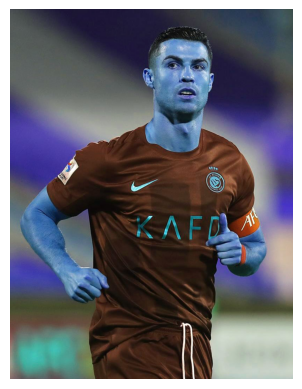

In [22]:
plt.imshow(test_img)
plt.axis("off")

In [23]:
test_img = cv2.resize(test_img,(224,224))

In [25]:
test_input = test_img.reshape((1,224,224,3))

In [27]:
predicted_class, confidence = predict(MODEL, test_input[i].numpy())

IndexError: index 8 is out of bounds for axis 0 with size 1

first image to predict
actual label: andriy_shevchenko
1/1 [==============================] - 0s 129ms/step
predicted label: andriy_shevchenko


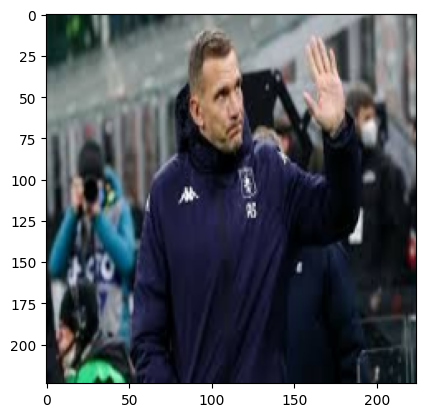

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    # first_image = images_batch[0].numpy().astype('uint8')
    first_image = (images_batch[0].numpy() * 255).astype('uint8')

    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",CLASS_NAME[first_label])

    batch_prediction = MODEL.predict(images_batch)
    print("predicted label:",CLASS_NAME[np.argmax(batch_prediction[0])])